# Adversarial Evasion Attacks Tutorial


---

In this notebook we explore how to create a model, train it, and then attack it with adversarial evasion attacks.

We are going to use PyTorch for defining a simple **Fully Connected Neural Network**,
then we will train it to classify a simple 5-class dataset with 2 features.

We will use the SecML Library for attacking the model with **Adversarial Attacks**.

## Imports

In [10]:
# we use these for the model
import torch
from torch import nn
from torch import optim
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.peval.metrics import CMetricAccuracy

# these are required for the dataset and preprocessing
from secml.data.loader import CDLRandomBlobs
from secml.data.splitter import CTrainTestSplit
from secml.ml.features import CNormalizerMinMax

# these are used for the adversarial attacks
from secml.optim.constraints import CConstraintL2
from secml.array import CArray
from secml.adv.attacks.evasion import CFoolboxPGDL2

# this is for visualization
from secml.figure import CFigure

## Dataset creation

---

We will create a 2D dataset, that is easy to play with and visualize.

In [2]:
random_state = 999

n_features = 2  # Number of features
n_samples = 1100  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2], [0, 1], [2, 0]]  # Centers of the clusters
cluster_std = 0.1  # Standard deviation of the clusters
n_classes = len(centers)

dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers, 
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

## Splitting, Preprocessing, Metrics

---

We have to create two separate groups of data: one is for training the model, 
and the other is used for scoring its performance.

Moreover, we will normalize the data in the interval [0, 1].

In [3]:
n_tr = 1000  # Number of training set samples
n_ts = 40  # Number of test set samples

# Split in training and test
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

# Metric to use for training and performance evaluation
metric = CMetricAccuracy()

## Model creation

---

Now we will create a Fully Connected Neural Network. We use PyTorch for this.

![fcnn](assets/nn_draw.png)

In [4]:
# Creation of the multiclass classifier
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# torch model creation
net = Net(n_features=n_features, n_classes=n_classes, n_hidden=100)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
clf = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         input_shape=(n_features,), 
                         random_state=random_state)

## Model training

---

SecML allows training the model with a simple utility method called `fit`.

Otherwise, for training a model with PyTorch, one usually has to write a loop that performs back-propagation (outside the scope of this tutorial).

Finally, we can compute the accuracy of our model on the test data.

In [11]:

# We can now fit the classifier
clf.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred) 

print("Accuracy on test set: {:.2%}".format(acc))


Accuracy on test set: 100.00%


## Attack creation

---

Now we will select a point and perturb it in order to reach another class, i.e., to be misclassified.

We use an $\ell_2$ perturbation here, for limiting the maximum Euclidean distance of the perturbed point from the original point to $\varepsilon$.

The PGD attack uses the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) for creating adversarial examples.

* Targeted attack: minimize CE Loss on the target class
* Untargeted attack: maximize the CE Loss on the original class

The Projected Gradient Descent (PGD) Attack (snapshot from the Foolbox library):
[![pgd-loop](assets/pgd_loop.png)](https://github.com/bethgelab/foolbox/blob/ca8bc831005b516953af0616785762311f858b40/foolbox/attacks/gradient_descent_base.py#L91)

For each iteration `i`:
1. computes the gradient of the loss w.r.t. the sample at iteration `i`
2. normalizes the gradient
3. performs a step in the gradient direction
4. projects the perturbed sample in the $\varepsilon$-ball
5. projects the perturbed sample in the range [0, 1] of the feature space.

<img src="assets/draw_advml.png" width="1300" height="900" />

In [12]:
x0, y0 = ts[5, :].X, ts[5, :].Y  # Initial sample
steps = 20  # Number of iterations
epsilon = 0.3  # Maximum perturbation
y_target = None  # None if `error-generic`, the label of the target class for `error-specific`
lb = tr.X.min()
ub = tr.X.max()

pgd_attack = CFoolboxPGDL2(clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=epsilon,
                           abs_stepsize=0.1,
                           steps=steps,
                           random_start=False)
y_pred, _, adv_ds_pgd, _ = pgd_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-L2): ", y_pred.item())

Original x0 label:  3
Adversarial example label (PGD-L2):  0


## Visualization

---

We will plot now the objective function of the attack, along with the starting point `x0`, and the optimization path computed with the attack.

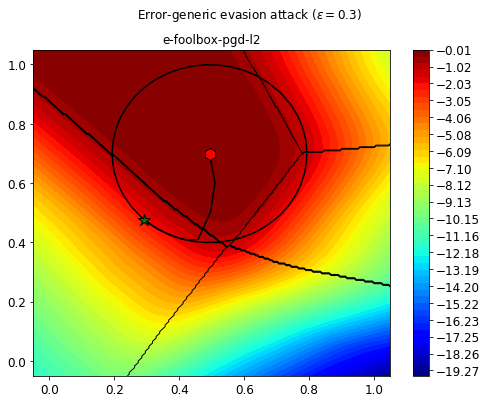

In [13]:
%matplotlib inline  
# required for visualization in notebooks

fig = CFigure(width=8, height=6, markersize=12)
constraint = CConstraintL2(center=x0, radius=epsilon)  # visualize the constraint

fig.sp.plot_fun(pgd_attack.objective_function, plot_levels=False,
                multipoint=True, n_grid_points=100)  # attack objective function
fig.sp.plot_decision_regions(clf, plot_background=False, 
                             n_grid_points=200)  # decision boundaries

# Construct an array with the original point and the adversarial example
adv_path = x0.append(pgd_attack.x_seq, axis=0)

fig.sp.plot_path(pgd_attack.x_seq)  # plots the optimization sequence
fig.sp.plot_constraint(constraint)  # plots the constraint

fig.sp.title(pgd_attack.class_type)
fig.sp.grid(grid_on=False)

fig.title(r"Error-generic evasion attack ($\varepsilon={:}$)".format(epsilon))
fig.show()

# Security Evaluation Curve

---

As final exercise for this notebook, we will plot the security evaluation curve. This is the accuracy of the model on the test points perturbed with increasing amounts of perturbation.

We espect that with a bigger perturbation we will get bigger error, i.e., lower accuracy.

Let's test that, once more with the SecML library.

Running security evaluation...


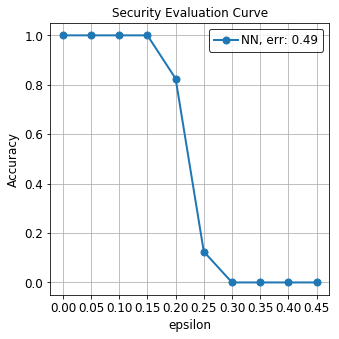

In [14]:
# Perturbation levels to test
e_vals = CArray.arange(start=0, step=0.05, stop=0.5)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_attack, param_name='epsilon', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.run_sec_eval(ts)

fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, marker='o', label='NN', show_average=True)
